In [2]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
model =init_chat_model("groq:qwen/qwen3-32b")

In [3]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages = [AIMessage(content=f"Please tell me how can i help",name="LLModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="siddu"))
messages.append(AIMessage(content=f"Please tell me which programming language you want to learn",name="LLModel"))

for msg in messages:
    msg.pretty_print()

================================== Ai Message ==================================
Name: LLModel

Please tell me how can i help
================================ Human Message =================================
Name: siddu

I want to learn coding
================================== Ai Message ==================================
Name: LLModel

Please tell me which programming language you want to learn


### Tools

In [4]:
def add(a:int,b:int)->int:
    """
    Args:
        a (int):first int
        b (int): second int

    Returns:
        int
    """

    return a+b

In [5]:
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 16384, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000020FCE340A50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020FCE348DD0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
### binding tool with llm

llm_with_tool = model.bind_tools([add])
tool_call = llm_with_tool.invoke([HumanMessage(content="what is 2 plus 2")])

In [7]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'az8a2g6th',
  'type': 'tool_call'}]

In [8]:
tool_call

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "what is 2 plus 2". Let me see. I need to figure out if I should use the add function provided. The function takes two integers, a and b. The user\'s question is straightforward addition. So, 2 plus 2 would be the same as adding a=2 and b=2. I should call the add function with those parameters. There\'s no ambiguity here, so the tool call is appropriate.\n', 'tool_calls': [{'id': 'az8a2g6th', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 124, 'prompt_tokens': 171, 'total_tokens': 295, 'completion_time': 0.210014691, 'completion_tokens_details': {'reasoning_tokens': 95}, 'prompt_time': 0.006827259, 'prompt_tokens_details': None, 'queue_time': 0.05629534, 'total_time': 0.21684195}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 

### Using Messages as state

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [10]:
initial_messages=  [AIMessage(content="please tell me how can i help")]
initial_messages.append(HumanMessage(content="I want to learn coding"))
initial_messages

[AIMessage(content='please tell me how can i help', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={})]

In [11]:
ai_message = AIMessage(content="Which programming language you want to learn")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={})

In [12]:
add_messages(initial_messages,ai_message)

[AIMessage(content='please tell me how can i help', additional_kwargs={}, response_metadata={}, id='7b4aeeb7-60aa-4ebc-8767-0c2b34671a7d'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, id='605594d6-db56-41e7-8125-08b441c08d44'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, id='91c39a1a-4bea-4d4f-818e-99be5264545f')]

In [13]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

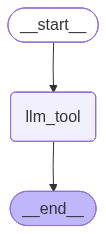

In [14]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

builder = StateGraph(State)
builder.add_node("llm_tool",llm_tool)
builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)


graph_builder = builder.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [15]:
messages = graph_builder.invoke({"messages":"what is 2+2"})

for message in messages["messages"]:
    print(message)

content='what is 2+2' additional_kwargs={} response_metadata={} id='2f5016dc-5144-489f-abe8-c853e21996eb'
content='' additional_kwargs={'reasoning_content': 'Okay, the user is asking "what is 2+2". Let me see. I need to figure out if I should use the provided function to solve this. The function given is called "add" and it takes two integers, a and b. The user\'s question is a simple addition problem, so the add function is exactly what\'s needed here. The parameters required are a and b, both integers. In this case, a is 2 and b is 2. So I should call the add function with these values. I need to make sure the arguments are correctly formatted as JSON within the tool_call tags. Let me double-check the function signature to confirm the parameters. Yep, looks good. No other functions are available, so this is the right choice. Let\'s generate the tool call with the arguments.\n', 'tool_calls': [{'id': '15vjh64b2', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'func

In [16]:
tools = [add]

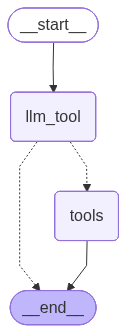

In [17]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges("llm_tool",tools_condition)
builder.add_edge("tools",END)


graph_builder = builder.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [18]:
messages = graph_builder.invoke({"messages":"what is 2+2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 2+2
================================== Ai Message ==================================
Tool Calls:
  add (32htqtpdd)
 Call ID: 32htqtpdd
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [19]:
messages = graph_builder.invoke({"messages":"what is Machine learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is Machine learning
================================== Ai Message ==================================

Machine Learning (ML) is a subset of **Artificial Intelligence (AI)** that focuses on developing algorithms and models that enable computers to learn patterns and make decisions from data, without being explicitly programmed for specific tasks. Here's a concise breakdown:

1. **Core Idea**:  
   ML systems improve their performance over time by learning from data. Instead of following strict rules, they identify patterns in input data to make predictions or take actions.

2. **Key Approaches**:  
   - **Supervised Learning**: Uses labeled data (input + desired output) to train models. Examples: predicting house prices (regression) or classifying emails as spam (classification).  
   - **Unsupervised Learning**: Finds hidden patterns in unlabeled data. Examples: clustering customers into groups or red

### Chatbot with multiple tools

In [20]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [21]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv  = ArxivQueryRun(
    api_wrapper=api_wrapper_arxiv
)

print(arxiv.name)

arxiv


In [22]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [23]:
arxiv.invoke("What is Machine Learning")

'Published: 2023-06-07\nTitle: Changing Data Sources in the Age of Machine Learning for Official Statistics\nAuthors: Cedric De Boom, Michael Reusens\nSummary: Data science has become increasingly essential for the production of official statistics, as it enables the automated collection, processing, and analysis of large amounts of data. With such data science practices in place, it enables more timely, more insightful and more flexible reporting. However, the quality and integrity of data-science-'

In [24]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [25]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\Siddu\AppData\Local\Temp\ipykernel_7076\1535493036.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [26]:
tavily.invoke("provide me recent AI news for december 12th 2025")

[{'title': "Three Biggest AI Stories in Dec. 2025: 'AI Litigation Task Force'",
  'url': 'https://etcjournal.com/2025/12/12/three-biggest-ai-stories-in-dec-2025-ai-litigation-task-force/',
  'content': "“AI News & Trends December 2025: Complete Monthly Digest,” by HumAI Editorial Team, HumAI blog, Dec 4, 2025: “Anthropic has released a new model, Claude Opus 4.5, which outperformed all human job candidates in the company’s internal engineering tests, setting a new record in AI capabilities.” [...] |  | NewsBites 2025 年 12… on NewsBites 2025 Dec 2: Gemini 3… |\n|  | Tether Data Launches… on Five Emerging AI Trends in Lat… |\n| Unknown's avatar | Observing shifts in… on Metaphors Shape Our Views of… |\n| Unknown's avatar | - Архитектура сознан… on Predictions for the Arrival of… |\n| Unknown's avatar | Anonymous on The Fast Curve Ball |\n|  | China’s DeepSe… on Status of DeepSeek’s R1 Model… |\n|  | Artificial Intellige… on When Will AI Surpass Humanity… | [...] “Trump targets state AI l

In [27]:
wiki_wrapper = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(
    api_wrapper=wiki_wrapper
)

wiki.name

'wikipedia'

In [28]:
## combine all the tools in a list
tools = [arxiv,wiki,tavily]

In [29]:
llm_with_tools = model.bind_tools(tools=tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 16384, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000020FCE340A50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020FCE348DD0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 

In [30]:
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'vxcz7r5wv',
  'type': 'tool_call'}]

In [31]:
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. The available tools are arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is for scientific papers, so if they wanted research papers on AI, that would be the one. But the user just said "recent AI news," which sounds more like current events or news articles rather than academic papers.\n\nWikipedia is for general knowledge and historical information. While AI topics might be covered there, it\'s not the best source for the latest news. Plus, Wikipedia updates can be slow for breaking news.\n\nTavily_search_results_json is described as a search engine optimized for current events. That fits perfectly here because the user is asking for recent news. So I should use tavily_search_results_json with a query like "recent AI news" or "latest AI developments."\n\nI need to structure the tool call correctly. The function name is tav

### Create Chatbot 

In [32]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [33]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

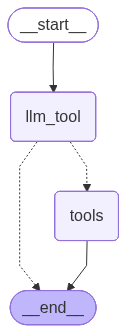

In [34]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

graph = builder.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [35]:
messages = graph.invoke({"messages":HumanMessage(content="what is attention is all you need")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  wikipedia (js9t7am62)
 Call ID: js9t7am62
  Args:
    query: Attention Is All You Need (paper)
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [36]:
messages = graph.invoke({"messages":HumanMessage(content="1706.03762")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (6h7x6z0rn)
 Call ID: 6h7x6z0rn
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [37]:
messages = graph.invoke({"messages":HumanMessage(content="what is machine learning")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (kzpmc83qw)
 Call ID: kzpmc83qw
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi


In [38]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me top 10 recent AI news for December 12th 2025")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me top 10 recent AI news for December 12th 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2ysex4j54)
 Call ID: 2ysex4j54
  Args:
    query: top 10 recent AI news December 12th 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "60 of our biggest AI announcements in 2025 - Google Blog", "url": "https://blog.google/technology/ai/google-ai-news-recap-2025/", "content": "We didn’t let up as we rounded the bend of 2025. Instead, we squeezed even more AI news into an already jam-packed year with the introduction of Gemini 3 Flash, our annual Year in Search release and still more announcements to round us out. Here were some of the top Google AI news stories of the month: [...] The return of Google I/O meant that many of the month’s biggest annou

### ReAct Agents

In [39]:
def multiply(a:int,b:int)->int:
    """Multiply a and b"""
    return a*b

def divide(a:int,b:int)->float:
    """Divide a and b"""
    return a/b

In [40]:
tools = [arxiv,wiki,add,multiply,divide,tavily]

In [41]:
llm_with_tools = model.bind_tools(tools)

In [42]:
llm_with_tools.invoke("what is recent AI news")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions. There\'s arxiv, wikipedia, add, multiply, divide, and tavily_search_results_json. The arxiv function is for scientific papers, which might be useful for technical updates. Wikipedia is for general knowledge, but it might not have the latest news. Tavily_search_results_json is described as a search engine for current events, so that sounds perfect for recent news. The other functions like add, multiply, divide are irrelevant here.\n\nSo, I should use tavily_search_results_json to get the latest AI news. The input should be a search query. The user wants recent AI news, so the query would be "recent AI news" or similar. I\'ll structure the tool call with that query. No need to mention other tools unless the user specifies a need for academic papers or general info. Since they asked for recent news, t

In [43]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

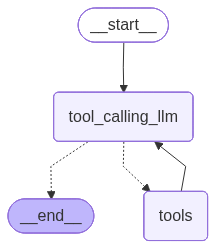

In [44]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me recent AI news for December 10th 2025, add 5 plus 5 and then multiply by 10")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me recent AI news for December 10th 2025, add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (zt6enx0nm)
 Call ID: zt6enx0nm
  Args:
    query: recent AI news December 10th 2025
  add (ed1v3jv13)
 Call ID: ed1v3jv13
  Args:
    a: 5
    b: 5
  multiply (mt63r7nvy)
 Call ID: mt63r7nvy
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI Insights: Key Global Developments in December 2025 - RiskInfo.ai", "url": "https://www.riskinfo.ai/post/ai-insights-key-global-developments-in-december-2025", "content": "This month’s news spans late November through mid-December 2025, and it’s been a whirlwind. The frontier of AI continues advancing: Google launched Gemini 3 (Nov 2025), its most powerful m

### Agent Memory

In [46]:
messages = graph.invoke({"messages":HumanMessage(content="what is 5 plus 8")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (37ft2fyrn)
 Call ID: 37ft2fyrn
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

The sum of 5 and 8 is **13**.


In [47]:
message = [HumanMessage(content="Divide that by 13")]
messages = graph.invoke({"messages":message})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide that by 13
================================== Ai Message ==================================

To perform the division, I need to know the specific number you want to divide by 13. Could you please provide the number? For example, if you want to divide 26 by 13, the result would be 2. Let me know the value you're referring to!


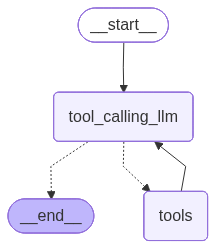

In [48]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

## view
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [49]:
## Specify the thread
config = {"configurable":{"thread_id":"1"}}
message = [HumanMessage(content="Add 12 and 14")]
messages = graph_memory.invoke({"messages":message},config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 14
================================== Ai Message ==================================
Tool Calls:
  add (hp13d27ww)
 Call ID: hp13d27ww
  Args:
    a: 12
    b: 14
================================= Tool Message =================================
Name: add

26
================================== Ai Message ==================================

The sum of 12 and 14 is **26**.


In [50]:
message = [HumanMessage(content="Add 13 and 13")]
messages = graph_memory.invoke({"messages":message},config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 14
================================== Ai Message ==================================
Tool Calls:
  add (hp13d27ww)
 Call ID: hp13d27ww
  Args:
    a: 12
    b: 14
================================= Tool Message =================================
Name: add

26
================================== Ai Message ==================================

The sum of 12 and 14 is **26**.
================================ Human Message =================================

Add 13 and 13
================================== Ai Message ==================================
Tool Calls:
  add (23kmtvb6q)
 Call ID: 23kmtvb6q
  Args:
    a: 13
    b: 13
================================= Tool Message =================================
Name: add

26
================================== Ai Message ==================================

The sum of 13 and 13 is **26**.


In [51]:
message = [HumanMessage(content="divide final answer with 13")]
messages = graph_memory.invoke({"messages":message},config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 14
================================== Ai Message ==================================
Tool Calls:
  add (hp13d27ww)
 Call ID: hp13d27ww
  Args:
    a: 12
    b: 14
================================= Tool Message =================================
Name: add

26
================================== Ai Message ==================================

The sum of 12 and 14 is **26**.
================================ Human Message =================================

Add 13 and 13
================================== Ai Message ==================================
Tool Calls:
  add (23kmtvb6q)
 Call ID: 23kmtvb6q
  Args:
    a: 13
    b: 13
================================= Tool Message =================================
Name: add

26
================================== Ai Message ==================================

The sum of 13 and 13 is **26**.
================================ Human Message =========================

### Streaming reponces

* updates parameter - this is the recent updated responce from a nonde
* Values parameter  - this is the full conversations from that node so far

In [52]:
## Specify the thread
config = {"configurable":{"thread_id":"2"}}
# message = [HumanMessage(content="Add 12 and 14")]
# messages = graph_memory.invoke({"messages":message},config=config)

# for m in messages["messages"]:
#     m.pretty_print()
for chunk in graph_memory.stream({"messages":"Hi, My name is siddardha and I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'tool_calling_llm': {'messages': [AIMessage(content="Hello Siddardha! It's great to meet you. Cricket is an amazing sport—do you follow any particular team or player closely? 😊", additional_kwargs={'reasoning_content': "Okay, the user introduced himself as Siddardha and mentioned he likes cricket. I need to respond appropriately. Since there's no specific question here, my goal is to acknowledge his introduction and maybe engage him in a conversation about cricket. Let me check if there are any functions I need to use here. The tools provided include functions for Arxiv, Wikipedia, adding, multiplying, dividing, and Tavily search. But in this case, the user isn't asking for any information that requires those tools. It's just a casual greeting. So I don't need to call any functions here. I should just reply warmly and perhaps ask him about his interest in cricket. Let me make sure I'm not missing any hidden queries. He didn't mention anything that needs factual answers or calculations

In [53]:
for chunk in graph_memory.stream({"messages":"Hi, My name is siddardha and I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is siddardha and I like cricket', additional_kwargs={}, response_metadata={}, id='2f433c09-fffb-4897-9977-e23e0941bd97'), AIMessage(content="Hello Siddardha! It's great to meet you. Cricket is an amazing sport—do you follow any particular team or player closely? 😊", additional_kwargs={'reasoning_content': "Okay, the user introduced himself as Siddardha and mentioned he likes cricket. I need to respond appropriately. Since there's no specific question here, my goal is to acknowledge his introduction and maybe engage him in a conversation about cricket. Let me check if there are any functions I need to use here. The tools provided include functions for Arxiv, Wikipedia, adding, multiplying, dividing, and Tavily search. But in this case, the user isn't asking for any information that requires those tools. It's just a casual greeting. So I don't need to call any functions here. I should just reply warmly and perhaps ask him about his interest

In [54]:
for chunk in graph_memory.stream({"messages":"Hi, and I like cricket,also like football"},config,stream_mode="updates"):
    print(chunk)

{'tool_calling_llm': {'messages': [AIMessage(content='That’s awesome! Cricket and football are both thrilling sports. Do you have a favorite team or player in either sport? Or a memorable moment you’ve enjoyed watching? 😊', additional_kwargs={'reasoning_content': 'Okay, the user mentioned they like both cricket and football. Let me think about how to respond.\n\nFirst, I should acknowledge their interest in both sports. Maybe ask about their favorite teams or players in each. That way, I can engage them in a conversation and learn more about their preferences.\n\nI need to make sure the response is friendly and open-ended. Perhaps mention something about the excitement of both sports. Also, check if there\'s any recent news or events in cricket or football they might be interested in. But since I don\'t have real-time data, I should avoid specific events unless I can use the tools provided. Wait, the tools include Wikipedia and Tavily search. Maybe I can offer to look up some info if t

In [55]:
for chunk in graph_memory.stream({"messages":"I love sports"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is siddardha and I like cricket', additional_kwargs={}, response_metadata={}, id='2f433c09-fffb-4897-9977-e23e0941bd97'), AIMessage(content="Hello Siddardha! It's great to meet you. Cricket is an amazing sport—do you follow any particular team or player closely? 😊", additional_kwargs={'reasoning_content': "Okay, the user introduced himself as Siddardha and mentioned he likes cricket. I need to respond appropriately. Since there's no specific question here, my goal is to acknowledge his introduction and maybe engage him in a conversation about cricket. Let me check if there are any functions I need to use here. The tools provided include functions for Arxiv, Wikipedia, adding, multiplying, dividing, and Tavily search. But in this case, the user isn't asking for any information that requires those tools. It's just a casual greeting. So I don't need to call any functions here. I should just reply warmly and perhaps ask him about his interest